In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, recall_score, make_scorer, precision_score

***
# Data loading and basic infos

In [2]:
df = pd.read_csv('bicycle_accidents_05_20_filtered.csv', sep = ';')

# catr should be an int
df = df.astype({'catr':int})

# We create a dateTime column
df['date'] = pd.to_datetime(df[['jour','mois','an', 'hrmn']]
                   .astype(str).apply(' '.join, 1), format='%d %m %Y %H:%M')

# We won't use the date variables anymore
df.drop(['an', 'mois', 'jour', 'hrmn'], axis=1, inplace=True)

# For lum, values 3 & 4 can be considered identical
df.lum.replace({4:3}, inplace=True)

In [3]:
print(df.shape)
df.head()

(74927, 16)


,grav,sexe,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ,age,date
0,4,1,5,2,1,1,3,2,2,0,1,1,0,1,59,2005-01-13 19:45:00
1,3,1,1,1,1,7,3,2,2,0,3,1,0,1,21,2005-01-19 10:45:00
2,4,1,1,1,9,1,3,2,2,0,1,1,0,1,72,2005-01-26 13:15:00
3,3,2,1,2,1,1,3,2,2,0,2,1,0,1,52,2005-01-03 13:30:00
4,4,1,3,1,1,1,3,2,2,0,1,1,0,1,75,2005-01-29 18:30:00


In [4]:
df.describe()

,grav,sexe,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ,age
count,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000,74927.000000
mean,3.429391,1.242543,1.543649,1.832210,2.116020,1.447636,3.804169,1.747795,2.053252,0.306298,1.133557,1.163786,0.116313,1.350141,39.789075
std,0.828758,0.428624,1.278655,0.373682,1.823412,1.502893,1.019650,0.692576,0.748590,0.732048,0.651295,0.707796,0.320602,1.163553,20.120241
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,22.000000
50%,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,37.000000
75%,4.000000,1.000000,1.000000,2.000000,3.000000,1.000000,4.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,55.000000
max,4.000000,2.000000,5.000000,2.000000,9.000000,9.000000,9.000000,4.000000,4.000000,3.000000,4.000000,9.000000,1.000000,8.000000,99.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74927 entries, 0 to 74926
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   grav    74927 non-null  int64         
 1   sexe    74927 non-null  int64         
 2   lum     74927 non-null  int64         
 3   agg     74927 non-null  int64         
 4   int     74927 non-null  int64         
 5   atm     74927 non-null  int64         
 6   catr    74927 non-null  int32         
 7   circ    74927 non-null  int64         
 8   nbv     74927 non-null  int64         
 9   vosp    74927 non-null  int64         
 10  plan    74927 non-null  int64         
 11  surf    74927 non-null  int64         
 12  infra   74927 non-null  int64         
 13  situ    74927 non-null  int64         
 14  age     74927 non-null  int64         
 15  date    74927 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(14)
memory usage: 8.9 MB


***
# Pre-processing

### Renaming and grouping values

int (intersections): too many values, we regroup:
- 0, 1, 9 as no_intersect ('other' is not helpful)
- 2, 3, 4, 5 as normal_crossing (they are similar kinds of intersections)

In [6]:
# Creating renaming/grouping dictionnaries

dict_grav = {1:'indemn', 2:'killed', 3:'heavy_hosp', 4:'light_hosp'}
dict_sexe = {1:'male', 2:'female'}
dict_lum = {1:'day', 2:'dawn_dusk', 3:'night_dark', 5:'night_w_light'}
dict_agg = {1:'out_of_city', 2:'in_city'}
dict_int = {0:'no_intersect', 1:'no_intersect', 2:'normal_crossing', 3:'normal_crossing', 4:'normal_crossing', 5:'normal_crossing', 6:'roundabout', 7:'square', 8:'railroad_crossing', 9:'no_intersect'}
dict_atm = {1:'normal', 2:'light_rain', 3:'heavy_rain', 4:'snow_hail', 5:'fog_smoke', 6:'wind_storm', 7:'dazzling', 8:'covered', 9:'other'}
dict_catr = {1:'highway', 2:'national', 3:'departmental', 4:'communal', 5:'not_public', 6:'parking_lot', 7:'speedway', 9:'other'}
dict_circ = {1:'one_way', 2:'two_ways', 3:'separated_ways', 4:'variable_ways'}
dict_vosp = {0:'none', 1:'bicycle_track', 2:'bicycle_lane', 4:'other_reserved'}
dict_plan = {0:'missing', 1:'rectilinear', 2:'left_curve', 3:'right_curve', 4:'S_curve'}
dict_surf = {1:'normal', 2:'wet', 3:'puddles', 4:'flooded', 5:'snow', 6:'mud', 7:'icy', 8:'grease', 9:'other'}
dict_infra = {0:'none', 1:'underground', 2:'bridge', 3:'interchange_ramp', 4:'railroad', 5:'dev_crossroad', 6:'pedestrian', 7:'toll_zone', 8:'other'}
dict_situ = {0:'none', 1:'on_road', 2:'on_emergency_lane', 3:'on_border', 4:'on_sidewalk', 5:'on_bicycle_track', 6:'on_other_special', 8:'other'}

In [7]:
# Replacing values using the previous dicts
df.grav.replace(dict_grav, inplace=True)
df.sexe.replace(dict_sexe, inplace=True)
df.lum.replace(dict_lum, inplace=True)
df['agg'].replace(dict_agg, inplace=True)
df.int.replace(dict_int, inplace=True)
df.atm.replace(dict_atm, inplace=True)
df.catr.replace(dict_catr, inplace=True)
df.circ.replace(dict_circ, inplace=True)
df.vosp.replace(dict_vosp, inplace=True)
df.plan.replace(dict_plan, inplace=True)
df.surf.replace(dict_surf, inplace=True)
df.infra.replace(dict_infra, inplace=True)
df.situ.replace(dict_situ, inplace=True)

In [8]:
# Let's have a look at our new dataframe
df.head(10)

,grav,sexe,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ,age,date
0,light_hosp,male,night_w_light,in_city,no_intersect,normal,departmental,two_ways,2,none,rectilinear,normal,none,on_road,59,2005-01-13 19:45:00
1,heavy_hosp,male,day,out_of_city,no_intersect,dazzling,departmental,two_ways,2,none,right_curve,normal,none,on_road,21,2005-01-19 10:45:00
2,light_hosp,male,day,out_of_city,no_intersect,normal,departmental,two_ways,2,none,rectilinear,normal,none,on_road,72,2005-01-26 13:15:00
3,heavy_hosp,female,day,in_city,no_intersect,normal,departmental,two_ways,2,none,left_curve,normal,none,on_road,52,2005-01-03 13:30:00
4,light_hosp,male,night_dark,out_of_city,no_intersect,normal,departmental,two_ways,2,none,rectilinear,normal,none,on_road,75,2005-01-29 18:30:00
5,heavy_hosp,male,day,in_city,roundabout,normal,departmental,0,2,none,missing,normal,underground,on_road,47,2005-01-23 18:00:00
6,heavy_hosp,male,day,in_city,normal_crossing,normal,communal,two_ways,2,none,rectilinear,normal,none,on_road,13,2005-01-04 16:45:00
7,light_hosp,male,day,in_city,no_intersect,normal,communal,two_ways,2,none,rectilinear,normal,none,on_road,12,2005-01-05 17:30:00
8,heavy_hosp,male,day,out_of_city,no_intersect,normal,departmental,two_ways,2,none,right_curve,normal,underground,on_road,59,2005-01-08 10:30:00
9,light_hosp,male,day,in_city,no_intersect,dazzling,departmental,two_ways,2,none,rectilinear,normal,none,on_road,77,2005-01-13 15:00:00


### Independance tests

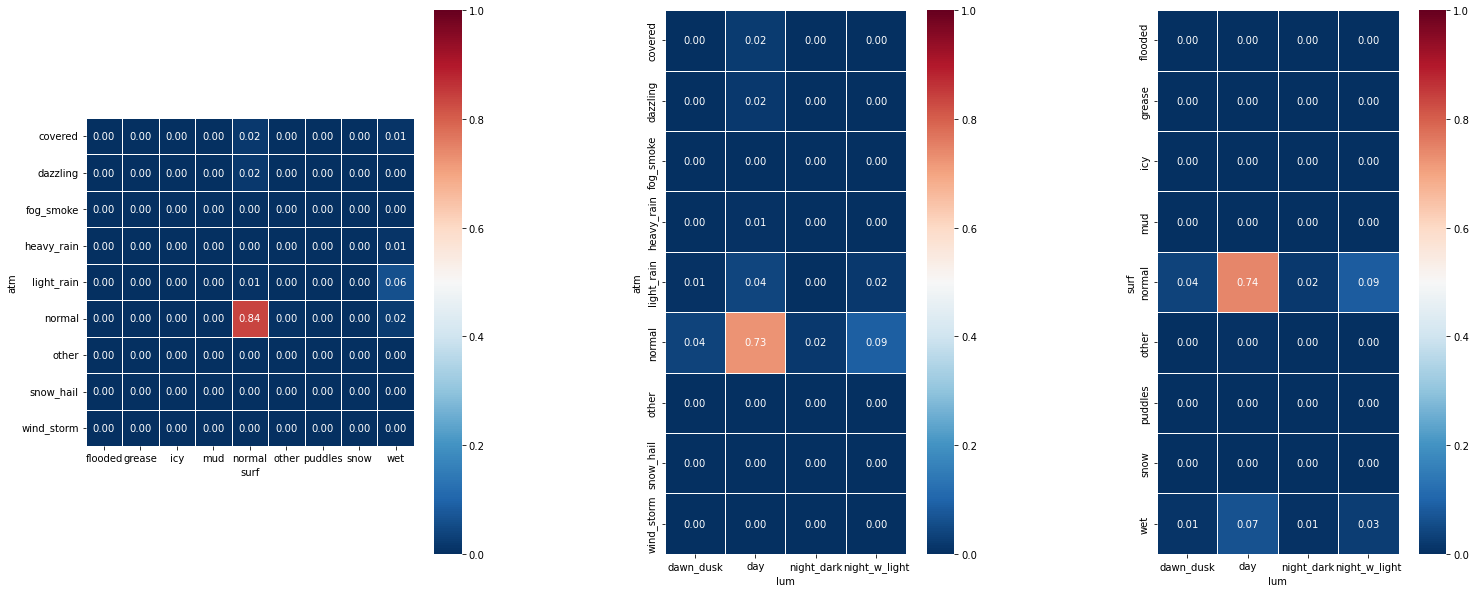

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))

sns.heatmap(pd.crosstab(df['atm'], df['surf'], normalize= True), ax = axes[0], annot=True, cmap="RdBu_r", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 1)
sns.heatmap(pd.crosstab(df['atm'], df['lum'], normalize= True), ax = axes[1], annot=True, cmap="RdBu_r", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 1)
sns.heatmap(pd.crosstab(df['surf'], df['lum'], normalize= True), ax = axes[2], annot=True, cmap="RdBu_r", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 1)
plt.show()

In [10]:
print("Cramer's V tests for weather-related features:")
print(f"atm and surf: {round(association(pd.crosstab(df['atm'], df['surf']), method='cramer'), 3)}")
print(f"atm and lum: {round(association(pd.crosstab(df['atm'], df['lum']), method='cramer'), 3)}")
print(f"surf and lum: {round(association(pd.crosstab(df['surf'], df['lum']), method='cramer'), 3)}")

Cramer's V tests for weather-related features:
atm and surf: 0.345
atm and lum: 0.116
surf and lum: 0.102


atm and surf are quite related, which makes sense. However lum (lighting conditions) is not really related to the other two.
We will simplify the weather conditions:
- lum stays unchanged
- surf:
  - we merge 'flooded', 'grease', 'mud', 'puddles' and 'wet' together as 'wet' (we can only know if it rains or not when planning a trip)
  - we merge 'icy' and 'snow' as 'icy'
  - we merge 'other' into 'normal'
- atm:
  - we merge 'covered' and 'dazzling' into 'normal' (we cannot know if we are into a dazzling situation, it depends on the time of the day and the precise location)
  - we merge 'heavy_rain' and 'light_rain' into 'rain'
  - we merge 'other' into 'normal'

In [11]:
# Modifying surf values
df.surf.replace({x:'wet' for x in ['flooded', 'grease', 'mud', 'puddles']}, inplace=True)
df.surf.replace({'snow':'icy'}, inplace=True)
df.surf.replace({'other':'normal'}, inplace=True)

# Modifying atm values
df.atm.replace({x:'normal' for x in ['covered', 'dazzling', 'other']}, inplace=True)
df.atm.replace({x:'rain' for x in ['heavy_rain', 'light_rain']}, inplace=True)

In [12]:
# We change the number of lanes as a category, instead of a number
df.nbv = df.nbv.astype('category')

### Using time data to create a pseudo-traffic

In [13]:
# We can simulate the traffic via the time of the accident: there is more traffic at the start and at the end of a work day
## Here we chose the ranges: 7h-9h and 16h-19h

def isHeavyTrafic(datetime):
    result = 0
    
    if ((7 <= datetime.hour) & (datetime.hour < 9)) | ((16 <= datetime.hour) & (datetime.hour < 19)):
        result = 1
    
    return result

df["heavy_traffic"] = df.date.apply(isHeavyTrafic)

# We also add the day of the week, we know there are more accidents on Friday for instance
df["dayofweek"] = df.date.dt.dayofweek

# We can remove the date column
df.drop('date', axis=1, inplace=True)

***
# Creating data and target

In [14]:
# We define our features and target, which is the accident gravity
data = df.drop('grav', axis = 1)
target = df.grav

In [15]:
# Dichotomization of the data
data = pd.get_dummies(data)

data.columns

Index(['age', 'heavy_traffic', 'dayofweek', 'sexe_female', 'sexe_male',
       'lum_dawn_dusk', 'lum_day', 'lum_night_dark', 'lum_night_w_light',
       'agg_in_city', 'agg_out_of_city', 'int_no_intersect',
       'int_normal_crossing', 'int_railroad_crossing', 'int_roundabout',
       'int_square', 'atm_fog_smoke', 'atm_normal', 'atm_rain',
       'atm_snow_hail', 'atm_wind_storm', 'catr_communal', 'catr_departmental',
       'catr_highway', 'catr_national', 'catr_not_public', 'catr_other',
       'catr_parking_lot', 'catr_speedway', 'circ_0', 'circ_one_way',
       'circ_separated_ways', 'circ_two_ways', 'circ_variable_ways', 'nbv_1',
       'nbv_2', 'nbv_3', 'nbv_4', 'vosp_3', 'vosp_bicycle_lane',
       'vosp_bicycle_track', 'vosp_none', 'plan_S_curve', 'plan_left_curve',
       'plan_missing', 'plan_rectilinear', 'plan_right_curve', 'surf_icy',
       'surf_normal', 'surf_wet', 'infra_none', 'infra_underground',
       'situ_none', 'situ_on_bicycle_track', 'situ_on_border',
      

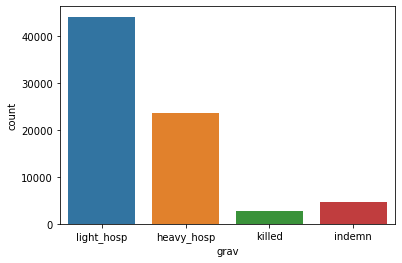

In [16]:
sns.countplot(x=target);

***
# Regrouping target values in two categories

Instead of having 4 gravity values, we can try to group them:
- indemn with light_hospitalized
- heavy_hospitalized with killed

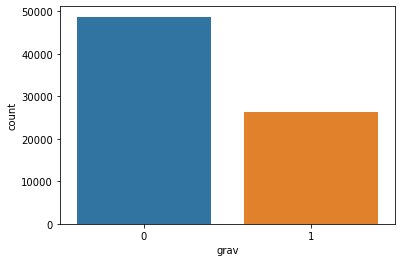

In [17]:
df.grav = df.grav.replace({"indemn":0, "light_hosp":0, "heavy_hosp":1, "killed":1})
target = df.grav

sns.countplot(x=target);

***
# Split train/test sets

In [18]:
# We split our training and test data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=4)

***
# Oversampling / undersampling

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler()
X_train_ro, y_train_ro = ros.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru).value_counts()))

# Centroids takes too long
#cc = ClusterCentroids()
#X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
#print('Classes échantillon CC :', dict(pd.Series(y_train_cc).value_counts()))

Classes échantillon oversampled : {0: 34106, 1: 34106}
Classes échantillon SMOTE : {0: 34106, 1: 34106}
Classes échantillon undersampled : {0: 18342, 1: 18342}


***
# Split, scaling, PCA (using UnderSampling)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ru)
X_test_scaled = scaler.transform(X_test)

In [129]:
from sklearn.decomposition import PCA

# Ajuste la PCA sur les données pour conserver 90% de la variance expliquée
pca = PCA(n_components = 0.90)

# Entraîne la PCA sur les données et les transforme, pour utilisation ultérieure (avec algo, puis score, etc...)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"La PCA crée {pca.n_components_} features, pour expliquer 90% de la variance ({X_train_scaled.shape[1]} à la base).")

La PCA crée 39 features, pour expliquer 90% de la variance (60 à la base).


***
# Making our own scorer

We want to make sure we estimate the danger properly: predicting no danger when there is one should be more problematic that the other way around.

In [26]:
#Define function for our new scorer: 

def Weigthed_geometric_mean(y, y_pred, Beta=1.1):
    recall= recall_score(y, y_pred, pos_label=1)
    precision= precision_score(y, y_pred, pos_label=1)
    return (precision * (recall**Beta))**(1/(1+Beta))

#define the scorer:
wgm_score= make_scorer(Weigthed_geometric_mean, Beta=1.1)

***
# Logistic Regression

D:\DataScience\Anaconda\envs\my_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "D:\DataScience\Anaconda\envs\my_env\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\DataScience\Anaconda\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\DataScience\Anaconda\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 44

Best lr parameters: {'C': 0.1, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Score LR : 58.72%
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     14619
           1       0.58      0.59      0.58      7860

    accuracy                           0.70     22479
   macro avg       0.68      0.68      0.68     22479
weighted avg       0.71      0.70      0.71     22479



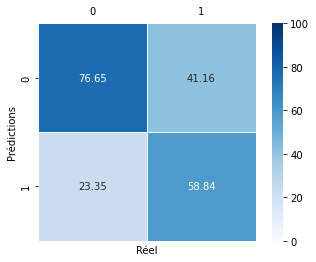

In [189]:
from sklearn.linear_model import LogisticRegression

# Best lr parameters: {'C': 0.1, 'max_iter': 500, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
param_grid_lr = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'C': np.arange(0.1, 0.6, 0.1),
                    'max_iter' : [100, 500, 1000],
                    "multi_class" : ["auto"],
                    "penalty" : ['l1', 'l2', 'elasticnet']}

clf_lr = LogisticRegression()

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3, n_jobs=4, scoring=wgm_score)
gcv_lr.fit(X_train_pca, y_train_ru)

print(f"Best lr parameters: {gcv_lr.best_params_}")

print(f"Score LR : {round(100*gcv_lr.score(X_test_pca, y_test),2)}%")

print(classification_report(y_test, gcv_lr.predict(X_test_pca)))

crosstab_lr = pd.crosstab(gcv_lr.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_lr, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# DecisionTreeClassifier

Best dtc parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}
Score DTC : 58.3%
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     14619
           1       0.56      0.59      0.57      7860

    accuracy                           0.69     22479
   macro avg       0.66      0.67      0.67     22479
weighted avg       0.70      0.69      0.69     22479



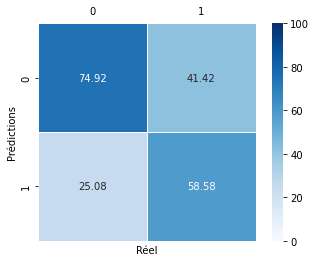

In [187]:
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier()

param_grid_dtc = {'criterion': ["gini", "entropy"],
                    'max_depth' : [7, 8, 9, 10, 11],
                    'min_samples_leaf': [2, 3, 4, 5, 6]}

gcv_dtc = GridSearchCV(clf_dtc, param_grid_dtc, cv=3, n_jobs=4, scoring=wgm_score)
gcv_dtc.fit(X_train_pca, y_train_ru)

print(f"Best dtc parameters: {gcv_dtc.best_params_}")

print(f"Score DTC : {round(100*gcv_dtc.score(X_test_pca, y_test),2)}%")

print(classification_report(y_test, gcv_dtc.predict(X_test_pca)))

crosstab_dtc = pd.crosstab(gcv_dtc.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_dtc, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# Bagging

0.6412877548795115
              precision    recall  f1-score   support

           0       0.77      0.66      0.71     14619
           1       0.50      0.62      0.55      7860

    accuracy                           0.65     22479
   macro avg       0.63      0.64      0.63     22479
weighted avg       0.67      0.65      0.66     22479



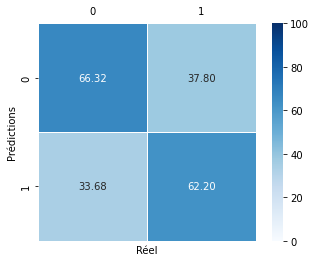

In [186]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(n_estimators=1000, oob_score=True)
bc.fit(X_train_pca, y_train_ru)

# Erreur Out of Bag
print(bc.oob_score_)

print(classification_report(y_test, bc.predict(X_test_pca)))

crosstab_bc = pd.crosstab(bc.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_bc, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# Random Forest

Best RF parameters: {'min_samples_leaf': 8, 'n_estimators': 350}
Score RandomForest : 61.78%
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     14619
           1       0.54      0.63      0.58      7860

    accuracy                           0.69     22479
   macro avg       0.66      0.67      0.67     22479
weighted avg       0.70      0.69      0.69     22479



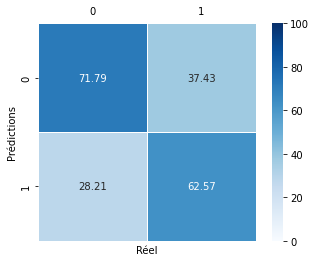

In [190]:
clf_rf = RandomForestClassifier(n_jobs=-1)

#Best RF parameters: {'n_estimators': 250, 'min_samples_leaf': 5}
param_grid_rf = [{'n_estimators': np.arange(350, 500, 50), 
                  'min_samples_leaf': np.arange(5, 11)}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf, cv=3, scoring=wgm_score)
gcv_rf.fit(X_train_pca, y_train_ru)

print(f"Best RF parameters: {gcv_rf.best_params_}")

print(f"Score RandomForest : {round(100*gcv_rf.score(X_test_pca, y_test),2)}%")

print(classification_report(y_test, gcv_rf.predict(X_test_pca)))

crosstab_rf = pd.crosstab(gcv_rf.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_rf, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# KNeighborsClassifier

Best KNC parameters: {'leaf_size': 1, 'n_neighbors': 9}
Score KNC : 60.624%
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     14619
           1       0.52      0.62      0.56      7860

    accuracy                           0.66     22479
   macro avg       0.64      0.65      0.65     22479
weighted avg       0.68      0.66      0.67     22479



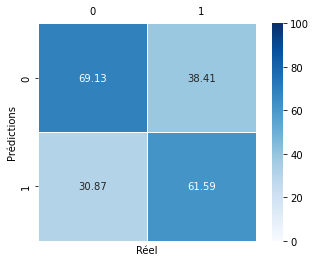

In [185]:
from sklearn.neighbors import KNeighborsClassifier

clf_knc = KNeighborsClassifier()

param_grid_knc = {'leaf_size': np.arange(1, 6, 1),
                    'n_neighbors': np.arange(5, 11)}

gcv_knc = GridSearchCV(clf_knc, param_grid_knc, cv=5, n_jobs=4, scoring=wgm_score)
gcv_knc.fit(X_train_pca, y_train_ru)

print(f"Best KNC parameters: {gcv_knc.best_params_}")

print(f"Score KNC : {round(100*gcv_knc.score(X_test_pca, y_test),3)}%")

print(classification_report(y_test, gcv_knc.predict(X_test_pca)))

crosstab_knc = pd.crosstab(gcv_knc.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_knc, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# RidgeClassifier

Best RC parameters: {'alpha': 1}
Score RC : 58.03%
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     14619
           1       0.58      0.58      0.58      7860

    accuracy                           0.71     22479
   macro avg       0.68      0.68      0.68     22479
weighted avg       0.71      0.71      0.71     22479



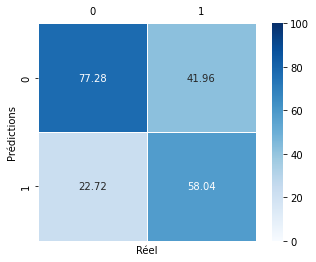

In [183]:
from sklearn.linear_model import RidgeClassifier

param_grid_rc = {'alpha': np.arange(1, 500, 5)}

clf_rc = RidgeClassifier()

gcv_rc = GridSearchCV(clf_rc, param_grid_rc, cv=10, n_jobs=6, scoring=wgm_score)
gcv_rc.fit(X_train_pca, y_train_ru)

print(f"Best RC parameters: {gcv_rc.best_params_}")
print(f"Score RC : {round(100*gcv_rc.score(X_test_pca, y_test),2)}%")

print(classification_report(y_test, gcv_rc.predict(X_test_pca)))

crosstab_rc = pd.crosstab(gcv_rc.predict(X_test_pca), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_rc, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

***
# LightGBM

Best LGBM parameters: {'learning_rate': 0.09999999999999999, 'num_leaves': 30, 'objective': 'binary', 'verbose': -1}
Score LGBM : 60.88%
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     14619
           1       0.56      0.65      0.61      7860

    accuracy                           0.70     22479
   macro avg       0.68      0.69      0.68     22479
weighted avg       0.71      0.70      0.71     22479



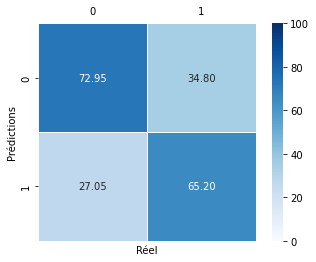

In [51]:
import lightgbm as lgb

best_params_LGBM =  {'feature_fraction': 0.4, 'learning_rate': 0.07, 'max_depth': -1000,
                    'num_leaves': 17, 'verbose': -1, 'objective':'binary'}

param_grid_LGBM =  {'learning_rate': np.arange(0.01, 0.11, 0.01),
                'num_leaves': np.arange(5, 31, 5), 'verbose': [-1], 'objective':['binary']}

#clf_LGBM = lgb.LGBMClassifier(**best_params_LGBM).fit(X_train,y_train)
clf_LGBM = lgb.LGBMClassifier()

gcv_LGBM = GridSearchCV(clf_LGBM, param_grid_LGBM, cv=10, n_jobs=6, scoring=wgm_score)
gcv_LGBM.fit(X_train_scaled, y_train_ru)

print(f"Best LGBM parameters: {gcv_LGBM.best_params_}")
print(f"Score LGBM : {round(100*gcv_LGBM.score(X_test_scaled, y_test),2)}%")

print(classification_report(y_test, gcv_LGBM.predict(X_test_scaled)))

crosstab_LGBM = pd.crosstab(gcv_LGBM.predict(X_test_scaled), y_test, rownames=["Prédictions"], colnames = ["Réel"], normalize= 'columns')

sns.heatmap(100*crosstab_LGBM, annot=True, cmap="Blues", square = True, fmt="0.2f", linewidths=1, vmin = 0, vmax = 100)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True); #To have the labels on top

In [54]:
clf_LGBM = lgb.LGBMClassifier(learning_rate= 0.1, num_leaves= 30, objective= 'binary', verbose= -1)
clf_LGBM.fit(X_train_scaled, y_train_ru)

LGBMClassifier(num_leaves=30, objective='binary', verbose=-1)

In [55]:
import shap

explainer = shap.TreeExplainer(clf_LGBM, feature_names=X_test.columns)
shap_values = explainer.shap_values(X_test_scaled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


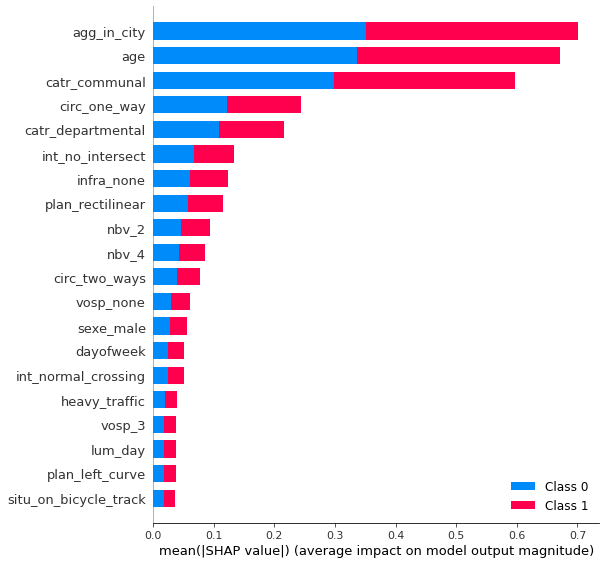

In [56]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names = X_test.columns)

In [73]:
explainer.expected_value

[-0.025389670424987, 0.025389670424987]

In [85]:
X_test.columns

Index(['age', 'heavy_traffic', 'dayofweek', 'sexe_female', 'sexe_male',
       'lum_dawn_dusk', 'lum_day', 'lum_night_dark', 'lum_night_w_light',
       'agg_in_city', 'agg_out_of_city', 'int_no_intersect',
       'int_normal_crossing', 'int_railroad_crossing', 'int_roundabout',
       'int_square', 'atm_fog_smoke', 'atm_normal', 'atm_rain',
       'atm_snow_hail', 'atm_wind_storm', 'catr_communal', 'catr_departmental',
       'catr_highway', 'catr_national', 'catr_not_public', 'catr_other',
       'catr_parking_lot', 'catr_speedway', 'circ_0', 'circ_one_way',
       'circ_separated_ways', 'circ_two_ways', 'circ_variable_ways', 'nbv_1',
       'nbv_2', 'nbv_3', 'nbv_4', 'vosp_3', 'vosp_bicycle_lane',
       'vosp_bicycle_track', 'vosp_none', 'plan_S_curve', 'plan_left_curve',
       'plan_missing', 'plan_rectilinear', 'plan_right_curve', 'surf_icy',
       'surf_normal', 'surf_wet', 'infra_none', 'infra_underground',
       'situ_none', 'situ_on_bicycle_track', 'situ_on_border',
      

In [80]:
X_test_scaled[3,:]

array([-1.16002083,  1.27954656, -1.50193596, -0.55303906,  0.55303906,
       -0.22455561,  0.46868915, -0.17341652, -0.33868903,  0.51072027,
       -0.51072027,  0.79169749, -0.65413533, -0.0342571 , -0.28113411,
       -0.10644596, -0.05306288, -3.36365863,  3.5308583 , -0.04277559,
       -0.04819199,  0.78864807, -0.67742039, -0.03177471, -0.18820988,
       -0.04903707, -0.15859037, -0.06429035, -0.05148995, -0.2515423 ,
        2.0596284 , -0.24994569, -1.46570827, -0.09291657,  2.28930082,
       -1.57065881, -0.23655559, -0.28517794, -0.18750999, -0.20897662,
       -0.32224613,  0.45238252, -0.10618372, -0.28400267, -0.27704872,
        0.52435223, -0.24945285, -0.05014191,  0.34272541, -0.33813871,
        0.37131723, -0.37131723, -0.22280881, -0.24902101, -0.17973666,
       -0.05509107, -0.03839533,  0.43928989, -0.13814819, -0.03944907])

In [104]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5], X_test_scaled[5,:], feature_names = X_test.columns)

In [103]:
myKBest = SelectKBest(k=10)
X_new = myKBest.fit_transform(X_train_ru, y_train_ru)
[X_train.columns[i] for i in myKBest.get_support(indices=True)]

['age',
 'agg_in_city',
 'agg_out_of_city',
 'int_no_intersect',
 'int_normal_crossing',
 'catr_communal',
 'catr_departmental',
 'circ_one_way',
 'circ_two_ways',
 'nbv_2']